# Look at the features generated by the PCA vs AE

In [1]:
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
###################################################
import torch
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
###################################################
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
###################################################
from livelossplot import PlotLosses
import hiddenlayer as hl
###################################################
import pickle
import os
###################################################
import scipy as sp
import scipy.fftpack

In [2]:
temp_nc = netCDF4.Dataset('../eniko/data/tas/tas_day_MPI-ESM-MR_rcp85_r1i1p1_g025.nc')
temp_ncdata_3D = np.array(temp_nc.variables['tas'])
temp_ncdata_2D = temp_ncdata_3D.reshape(temp_ncdata_3D.shape[0], temp_ncdata_3D.shape[1]*temp_ncdata_3D.shape[2])        

dates = pd.to_datetime(netCDF4.num2date(temp_nc.variables['time'][:], temp_nc.variables['time'].units)).year
temp_ncdata_df = pd.DataFrame(temp_ncdata_2D, index = dates)

In [32]:
train_start = 2025
train_end = 2100

test_start = 1975
test_end = 2075

max_fts = 10
batch_size = 717

In [33]:
# PCA type
train_idx = temp_ncdata_df.index.isin(range(train_start,train_end+1))
train_samples = temp_ncdata_df.iloc[train_idx]
train_years = temp_ncdata_df.index[temp_ncdata_df.index.isin(range(train_start,train_end+1))]

test_idx = temp_ncdata_df.index.isin(range(test_start,test_end+1))
test_samples = temp_ncdata_df.iloc[test_idx]
test_years = temp_ncdata_df.index[temp_ncdata_df.index.isin(range(test_start,test_end+1))]

# Standardise the training samples
train_samples = torch.tensor(train_samples.values)#.double()
test_samples = torch.tensor(test_samples.values)#.double()

mu, sig = train_samples.mean(), train_samples.std()

# train_samples = train_samples.sub(mu).div(sig)
# test_samples = test_samples.sub(mu).div(sig)

mmin = min(train_samples.min(),test_samples.min())
mmax = max(train_samples.max(),test_samples.max())

# # Normalise instead
train_samples = (train_samples - mmin) / (mmax - mmin)
test_samples = (test_samples - mmin) / (mmax - mmin)


train_data = DataLoader(train_samples, batch_size=batch_size)
test_data = DataLoader(test_samples, batch_size=batch_size)

# Load PCA

In [7]:
with open('data/models/pca/pca_512_2025_to_2100.pickle', 'rb') as file:
    pca_model = pickle.load(file)

In [7]:
# PCA features

In [25]:
from matplotlib.ticker import MaxNLocator

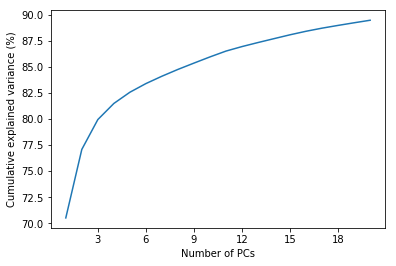

In [56]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(np.linspace(1,20,20),np.cumsum(pca_model.explained_variance_ratio_)[0:20]*100)
# plt.xlim(1,30)
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative explained variance (%)")
plt.savefig('data/images/report/pca_explained_var.pdf')

plt.show()

In [16]:
rmses_over_pcs = np.zeros(20)
loss = nn.MSELoss()

In [17]:
for k in tqdm(range(20)):
    with open('data/models/pca/pca_{}_2025_to_2100.pickle'.format(k+1), 'rb') as file:
        pca_model = pickle.load(file)
    
    recon_img = np.empty(shape=(0,72*144))
    for train_dat in train_data:
        transformed_img = pca_model.transform(train_dat)
        inv = pca_model.inverse_transform(transformed_img)
        recon_img = np.append(recon_img, inv, axis=0)
    
#     import pdb; pdb.set_trace()
    mse = loss(train_data.dataset.double(), torch.tensor(recon_img))
    rmses_over_pcs[k] = np.sqrt(mse)
    
    
    

100%|██████████| 20/20 [02:51<00:00,  8.59s/it]


In [15]:
test_rmses = rmses_over_pcs

In [18]:
train_rmses = rmses_over_pcs

In [21]:
test_rmses.shape

(20,)

In [22]:
train_rmses.shape

(20,)

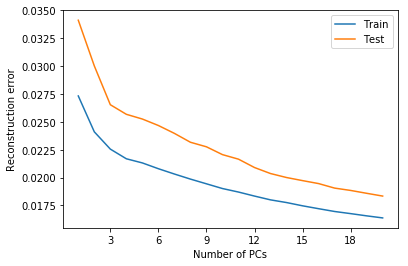

In [29]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(range(1,21,1), train_rmses, label='Train')
plt.plot(range(1,21,1), test_rmses, label='Test')


plt.xlabel("Number of PCs")
plt.ylabel("Reconstruction error")
plt.legend()

plt.savefig('data/images/report/pca_rmse_error.pdf')


plt.show()

In [30]:
pca_models = []
for k in [1,5,10]:
    with open('data/models/pca/pca_{}_2025_to_2100.pickle'.format(k), 'rb') as file:
        pca_model = pickle.load(file)
    
    pca_models.append(pca_model)

In [31]:
pca_models

[IncrementalPCA(batch_size=None, copy=True, n_components=1, whiten=False),
 IncrementalPCA(batch_size=None, copy=True, n_components=5, whiten=False),
 IncrementalPCA(batch_size=None, copy=True, n_components=10, whiten=False)]

In [37]:
train_data.dataset[1500].shape

torch.Size([10368])

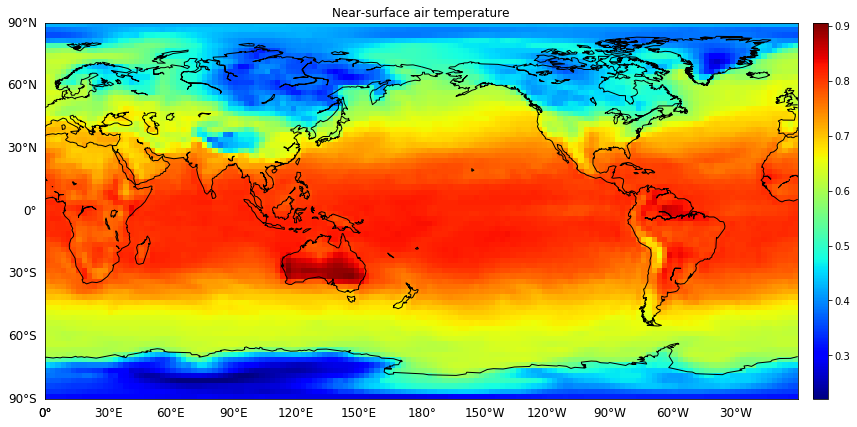

In [77]:
fig = plt.figure(figsize=(12,6))
long = [0, 360]
lat = [-90, 90]

map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
map.drawcoastlines()
map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

h = map.imshow(train_data.dataset[1500].reshape(72,144), cmap = 'jet', interpolation = 'none', animated = True)
map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
plt.title("Near-surface air temperature")
plt.tight_layout()
plt.savefig('data/images/report/original_1500.pdf')

In [78]:
pcs = [1,5,10]

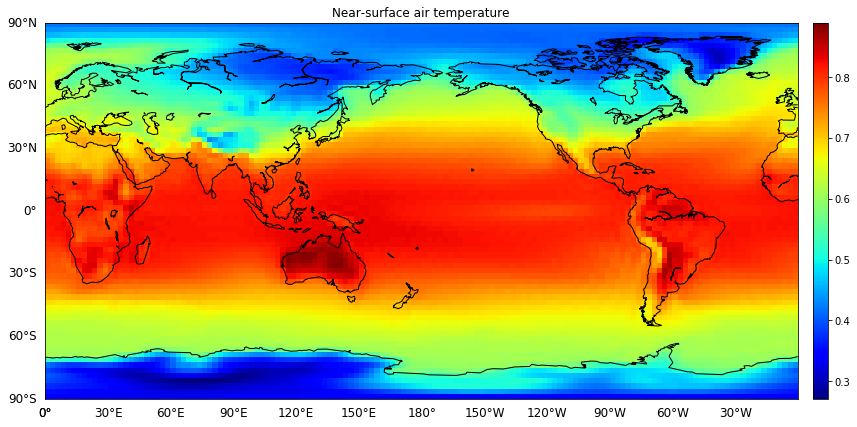

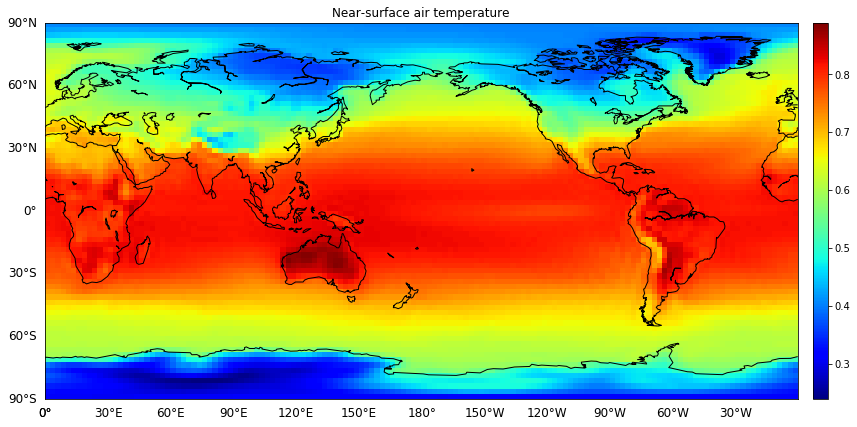

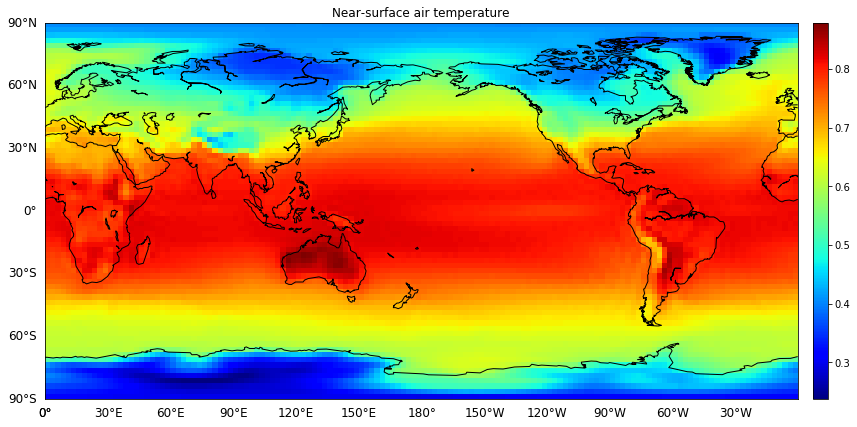

In [79]:
for k in range(3):
    fig = plt.figure(figsize=(12,6))
    long = [0, 360]
    lat = [-90, 90]

    map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
    map.drawcoastlines()
    map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
    map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

    transformed_img = pca_models[k].transform(train_data.dataset[1500].reshape(1,-1))

    inv = pca_models[k].inverse_transform(transformed_img)

    h = map.imshow(inv.reshape(72,144), cmap = 'jet', interpolation = 'none', animated = True)
    map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
    plt.title("Near-surface air temperature")
    plt.tight_layout()
    plt.savefig('data/images/report/pca_{}_1500.pdf'.format(pcs[k]))

# Load Autoencoder

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, layers):
        super(AutoEncoder,self).__init__()
        assert len(layers) == 5, 'Not the right number of layer numbers'
        self.encoder = nn.Sequential(
            nn.Conv2d(1, layers[0], kernel_size=(3,5))
            ,nn.MaxPool2d(2)
            ,nn.ReLU()
            
            ,nn.Conv2d(layers[0], layers[1], kernel_size=(2,5))
            ,nn.MaxPool2d((2,3))
            ,nn.ReLU()
            
            ,nn.Conv2d(layers[1], layers[2], kernel_size=(2,3))
            ,nn.MaxPool2d(2)
            ,nn.ReLU()
            
            ,nn.Conv2d(layers[2], layers[3], kernel_size=(3,3))
            ,nn.MaxPool2d(2)
            ,nn.ReLU()
            
            ,nn.Conv2d(layers[3], layers[4], kernel_size=(2,3))
            ,nn.MaxPool2d(2)
        )
        
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(layers[4], layers[3], kernel_size=(3,4), stride=(3,4))
            ,nn.ReLU()
                    
            ,nn.ConvTranspose2d(layers[3], layers[2], kernel_size=(3,3), stride=(3,3))
            ,nn.ReLU()
            
            ,nn.ConvTranspose2d(layers[2], layers[1], kernel_size=(2,3), stride=(2,3))
            ,nn.ReLU()
            
#             ,nn.PixelShuffle(2)
            
            ,nn.ConvTranspose2d(layers[1], layers[0], kernel_size=2, stride=2)
            ,nn.ReLU()
                       
            ,nn.ConvTranspose2d(layers[0], 1, kernel_size=(2,2), stride=(2,2))
            ,nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder part
        y = self.encoder(x)
        # Decoder part
        x = self.decoder(y)
        return y, x # x is the output of the autoencoder, y is the output of the encoder

In [7]:
bottleneck=64

In [8]:
# ae_model = 'data/models/autoencoder/ae_reg_TV_True_BN_False_{}_2025_to_2100_20_epochs.pickle'.format(bottleneck)
ae_model = 'data/models/autoencoder/ae_reg_TV_False_BN_False_256_2025_to_2100_20_epochs.pickle'
model = AutoEncoder(layers=[8,32,64,128,256])
model.load_state_dict(torch.load(ae_model))
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 32, kernel_size=(2, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(2, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(2, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 4), stride=(3, 4))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), 

In [31]:
y, x = model(test_data.dataset[0].reshape(1,1,72,144))

In [32]:
y.shape

torch.Size([1, 384, 1, 1])

In [33]:
x.shape

torch.Size([1, 1, 72, 144])

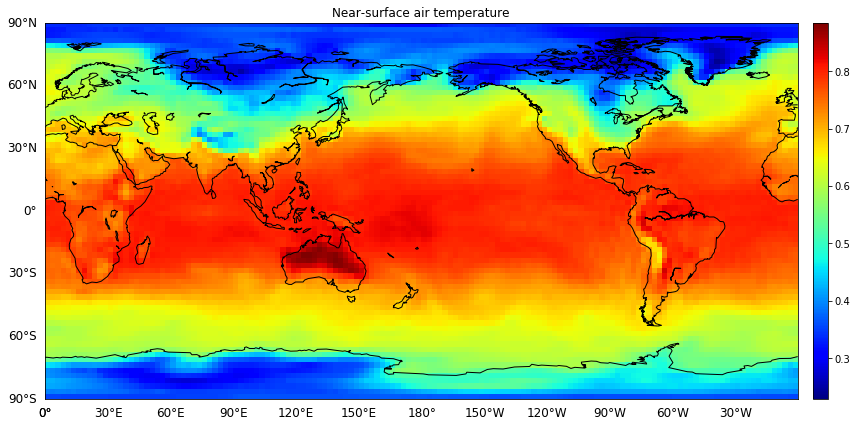

In [34]:
fig = plt.figure(figsize=(12,6))
long = [0, 360]
lat = [-90, 90]

map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
map.drawcoastlines()
map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

h = map.imshow(test_data.dataset[0].reshape(72,144), cmap = 'jet', interpolation = 'none', animated = True)
map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
plt.title("Near-surface air temperature")
plt.tight_layout()
plt.savefig('data/images/report/ae_test_original.pdf')

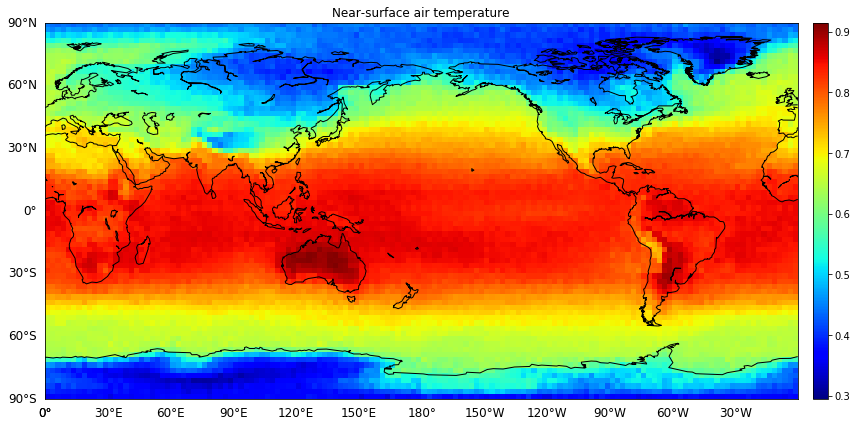

In [35]:
fig = plt.figure(figsize=(12,6))
long = [0, 360]
lat = [-90, 90]

map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
map.drawcoastlines()
map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

h = map.imshow(x.detach().numpy().reshape(72,144), cmap = 'jet', interpolation = 'none', animated = True)
map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
plt.title("Near-surface air temperature")
plt.tight_layout()
plt.savefig('data/images/report/ae_test_384.pdf')

# Load PCA on autoencoder

In [54]:
with open('data/models/autoencoder/pca_on_ae_{}_2025_to_2100.pickle'.format(bottleneck), 'rb') as file:
    pca_on_ae_model = pickle.load(file)

# Load the test time series

In [14]:
# Untrained model
# model=AutoEncoder(layers=[4,8,16,32,64])

In [48]:
bottleneck = 256

In [56]:
# pca_ts = np.empty(shape=(0,512))
# ae_ts = np.empty(shape=(0,bottleneck))
pca_on_ae_ts = np.empty(shape=(0,256)) # We fix the number of PCs on the AE to be 64 (unless it is lower)- the rest are quite noisy

In [57]:
for test_dat in tqdm(test_data):      
    # Plain PCA
#     transformed_img = pca_model.transform(test_dat)
#     pca_ts = np.append(pca_ts, transformed_img, axis=0)
    
    # Autoencoder
    encoded, _ = model(test_dat.reshape(-1, 72, 144).unsqueeze(1))
#     ae_ts = np.append(ae_ts, encoded.detach().numpy().reshape(-1,bottleneck), axis=0)
    
    # PCA on autoencoder
    transformed_img_bottleneck = pca_on_ae_model.transform(encoded.detach().numpy().reshape(-1,bottleneck))
    pca_on_ae_ts = np.append(pca_on_ae_ts, transformed_img_bottleneck, axis=0)


100%|██████████| 52/52 [00:36<00:00,  1.42it/s]


In [36]:
ae_ts.shape

(36890, 256)

In [58]:
pca_on_ae_ts.shape

(36890, 256)

In [18]:
pca_ts.shape

NameError: name 'pca_ts' is not defined

# Write some functions to visualise the features (512 of them)

In [76]:
# 512 // 16 // 8 == 4

## Make 32 plots per page

In [94]:
def time_freq_pair(datelist, series, series_type, components, test_start, test_end, bottleneck):
    fig, ax = plt.subplots(16,4, figsize=(20,30))
    
    for i in range(16):
    
        ax[i, 0].plot(datelist, series[:,i], color="black")
        if i == 15:
            ax[i, 0].tick_params(axis="x", labelsize=10, rotation=45)    
        if i != 15:    
            ax[i, 0].set_xticks([])
#         ax[i, 0].set_yticks([])
        ax[i, 0].yaxis.tick_left()
        ax[i, 0].grid('off')
        ax[i, 0].set_ylabel('c {}'.format(components[i], fontsize=16, color='r'))

        signal_fft = sp.fftpack.fft(series[:,i])
        power_spectrum = np.abs(signal_fft) ** 2
        fftfreq = sp.fftpack.fftfreq(len(power_spectrum), 1. / 365) # The frequencies will come out as YEARLY if we do this
        j = fftfreq > 0 # Only get the real ones
        ax[i, 1].loglog(fftfreq[j], power_spectrum[j], color="black")
        ax[i, 1].set_xlim(0.1, 370)
        if i == 15:
            ax[i, 1].set_xlabel('Frequency (1 / year)', fontsize=10)
            ax[i, 1].tick_params(axis="x", labelsize=10, rotation=0) 
        if i != 15:
            ax[i, 1].set_xticks([])
        ax[i, 1].yaxis.tick_right()
        ax[i, 1].set_ylim(0.01, 1e9)
        ax[i, 1].axvline(x=1, linewidth=1, color='green')
        ax[i, 1].axvline(x=2, linewidth=1, color='green')
        ax[i, 1].axvline(x=3, linewidth=1, color='green')
        ax[i, 1].axvline(x=4, linewidth=1, color='red')
        ax[i, 1].axvline(x=12, linewidth=1, color='red')
                            
        ax[i, 2].plot(datelist, series[:,i+16], color="black")
        if i == 15:
            ax[i, 2].tick_params(axis="x", labelsize=10, rotation=45)    
        if i != 15:    
            ax[i, 2].set_xticks([])
#         ax[i, 2].set_yticks([])
        ax[i, 2].yaxis.tick_left()
        ax[i, 2].grid('off')
        ax[i, 2].set_ylabel('c {}'.format(components[i+16], fontsize=16, color='r'))

        signal_fft = sp.fftpack.fft(series[:,i+16])
        power_spectrum = np.abs(signal_fft) ** 2
        fftfreq = sp.fftpack.fftfreq(len(power_spectrum), 1. / 365) # The frequencies will come out as YEARLY if we do this
        j = fftfreq > 0 # Only get the real ones
        ax[i, 3].loglog(fftfreq[j], power_spectrum[j], color="black")
        ax[i, 3].set_xlim(0.1, 370)
        if i == 15:
            ax[i, 3].set_xlabel('Frequency (1 / year)', fontsize=10)
            ax[i, 3].tick_params(axis="x", labelsize=10, rotation=0) 
        if i != 15:
            ax[i, 3].set_xticks([])
        ax[i, 3].yaxis.tick_right()
        ax[i, 3].set_ylim(0.01, 1e9)
        ax[i, 3].axvline(x=1, linewidth=1, color='green')
        ax[i, 3].axvline(x=2, linewidth=1, color='green')
        ax[i, 3].axvline(x=3, linewidth=1, color='green')
        ax[i, 3].axvline(x=4, linewidth=1, color='red')
        ax[i, 3].axvline(x=12, linewidth=1, color='red')
    
    fig.tight_layout()
    
#     if series_type == 'pca':
#         fig.savefig('data/images/{}/series_components_pc_{}_{}_to_{}_for_{}_{}.pdf'.format('pca', bottleneck, components[0],components[-1],test_start,test_end))
#     elif series_type == 'pca_on_ae':
#         fig.savefig('data/images/{}/series_components_pc_on_ae_bottleneck_{}_{}_to_{}_for_{}_{}.pdf'.format('autoencoder',bottleneck,components[0],components[-1],test_start,test_end))
#     else:    
#         fig.savefig('data/images/{}/series_components_autoencoder_bottleneck_{}_{}_to_{}_for_{}_{}.pdf'.format(series_type,bottleneck,components[0],components[-1],test_start,test_end))
                            


In [46]:
# Does 16 = 8 * 2 
def time_freq_pair(datelist, series, series_type, components, test_start, test_end, bottleneck):
    fig, ax = plt.subplots(8,4, figsize=(15,20))
    
    for i in range(8):
    
        ax[i, 0].plot(datelist, series[:,i], color="black")
        if i == 7:
            ax[i, 0].tick_params(axis="x", labelsize=20, rotation=45)    
        if i != 7:    
            ax[i, 0].set_xticks([])
#         ax[i, 0].set_yticks([])
        ax[i, 0].yaxis.tick_left()
        ax[i, 0].grid('off')
        ax[i, 0].set_ylabel('c {}'.format(components[i]), fontsize=20)
        ax[i, 0].tick_params(axis='both', which='major', labelsize=20)
        
        signal_fft = sp.fftpack.fft(series[:,i])
        power_spectrum = np.abs(signal_fft) ** 2
        fftfreq = sp.fftpack.fftfreq(len(power_spectrum), 1. / 365) # The frequencies will come out as YEARLY if we do this
        j = fftfreq > 0 # Only get the real ones
        ax[i, 1].loglog(fftfreq[j], power_spectrum[j], color="black")
        ax[i, 1].set_xlim(0.1, 370)
        if i == 7:
            ax[i, 1].set_xlabel('Frequency (1 / year)', fontsize=20)
            ax[i, 1].tick_params(axis="x", labelsize=10*2, rotation=0) 
        if i != 7:
            ax[i, 1].set_xticks([])
        ax[i, 1].yaxis.tick_left()
        ax[i, 1].set_ylim(0.01, 1e9)
        ax[i, 1].axvline(x=1, linewidth=1, color='green')
        ax[i, 1].axvline(x=2, linewidth=1, color='green')
        ax[i, 1].axvline(x=3, linewidth=1, color='green')
        ax[i, 1].axvline(x=4, linewidth=1, color='red')
        ax[i, 1].axvline(x=12, linewidth=1, color='red')
        ax[i, 1].tick_params(axis='both', which='major', labelsize=20)

                            
        ax[i, 2].plot(datelist, series[:,i+8], color="black")
        if i == 7:
            ax[i, 2].tick_params(axis="x", labelsize=20, rotation=45)    
        if i != 7:    
            ax[i, 2].set_xticks([])
#         ax[i, 2].set_yticks([])
        ax[i, 2].yaxis.tick_left()
        ax[i, 2].grid('off')
        ax[i, 2].set_ylabel('c {}'.format(components[i+8]), fontsize=20)
        ax[i, 2].tick_params(axis='both', which='major', labelsize=20)


        signal_fft = sp.fftpack.fft(series[:,i+8])
        power_spectrum = np.abs(signal_fft) ** 2
        fftfreq = sp.fftpack.fftfreq(len(power_spectrum), 1. / 365) # The frequencies will come out as YEARLY if we do this
        j = fftfreq > 0 # Only get the real ones
        ax[i, 3].loglog(fftfreq[j], power_spectrum[j], color="black")
        ax[i, 3].set_xlim(0.1, 370)
        if i == 7:
            ax[i, 3].set_xlabel('Frequency (1 / year)', fontsize=20)
            ax[i, 3].tick_params(axis="x", labelsize=20, rotation=0) 
        if i != 7:
            ax[i, 3].set_xticks([])
        ax[i, 3].yaxis.tick_left()
        ax[i, 3].set_ylim(0.01, 1e9)
        ax[i, 3].axvline(x=1, linewidth=1, color='green')
        ax[i, 3].axvline(x=2, linewidth=1, color='green')
        ax[i, 3].axvline(x=3, linewidth=1, color='green')
        ax[i, 3].axvline(x=4, linewidth=1, color='red')
        ax[i, 3].axvline(x=12, linewidth=1, color='red')
        ax[i, 3].tick_params(axis='both', which='major', labelsize=20)

    
    plt.tight_layout()
    
#     plt.subplots_adjust(wspace=0.4)

    
    if series_type == 'pca':
        fig.savefig('data/images/report/series_components_{}_{}_{}_to_{}_for_{}_{}.pdf'.format('pca', bottleneck, components[0],components[-1],test_start,test_end))
    elif series_type == 'pca_on_ae':
        fig.savefig('data/images/report/{}_series_components_pc_on_ae_bottleneck_{}_{}_to_{}_for_{}_{}.pdf'.format(series_type,bottleneck,components[0],components[-1],test_start,test_end))
    else:    
        fig.savefig('data/images/report/{}_series_components_autoencoder_bottleneck_{}_{}_to_{}_for_{}_{}.pdf'.format(series_type,bottleneck,components[0],components[-1],test_start,test_end))
                            


In [63]:
years_to_plot = 100

In [64]:
datelist = pd.date_range(pd.to_datetime(str(test_start) + '0101', format='%Y%m%d'), periods=365*years_to_plot).tolist()

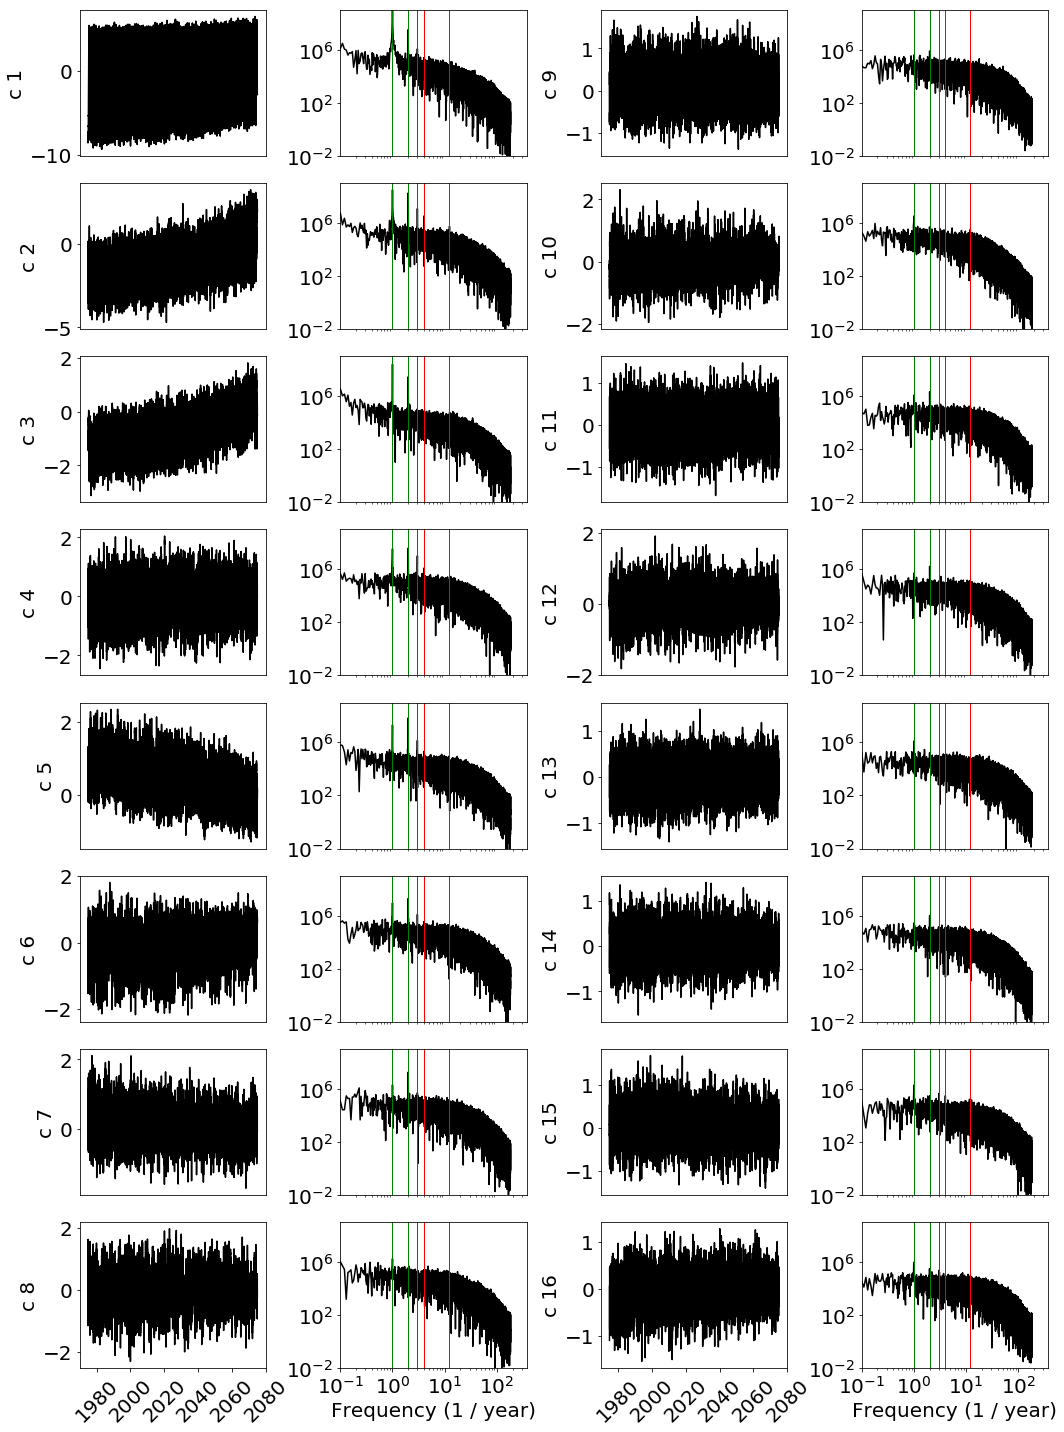

In [37]:
for j in range(1):
    time_freq_pair(datelist, pca_ts[0:(365*years_to_plot),(32*j):(32*(j+1))], 'pca', range(1+32*j,1+32*(j+1)), test_start, test_end
                   ,bottleneck=512)

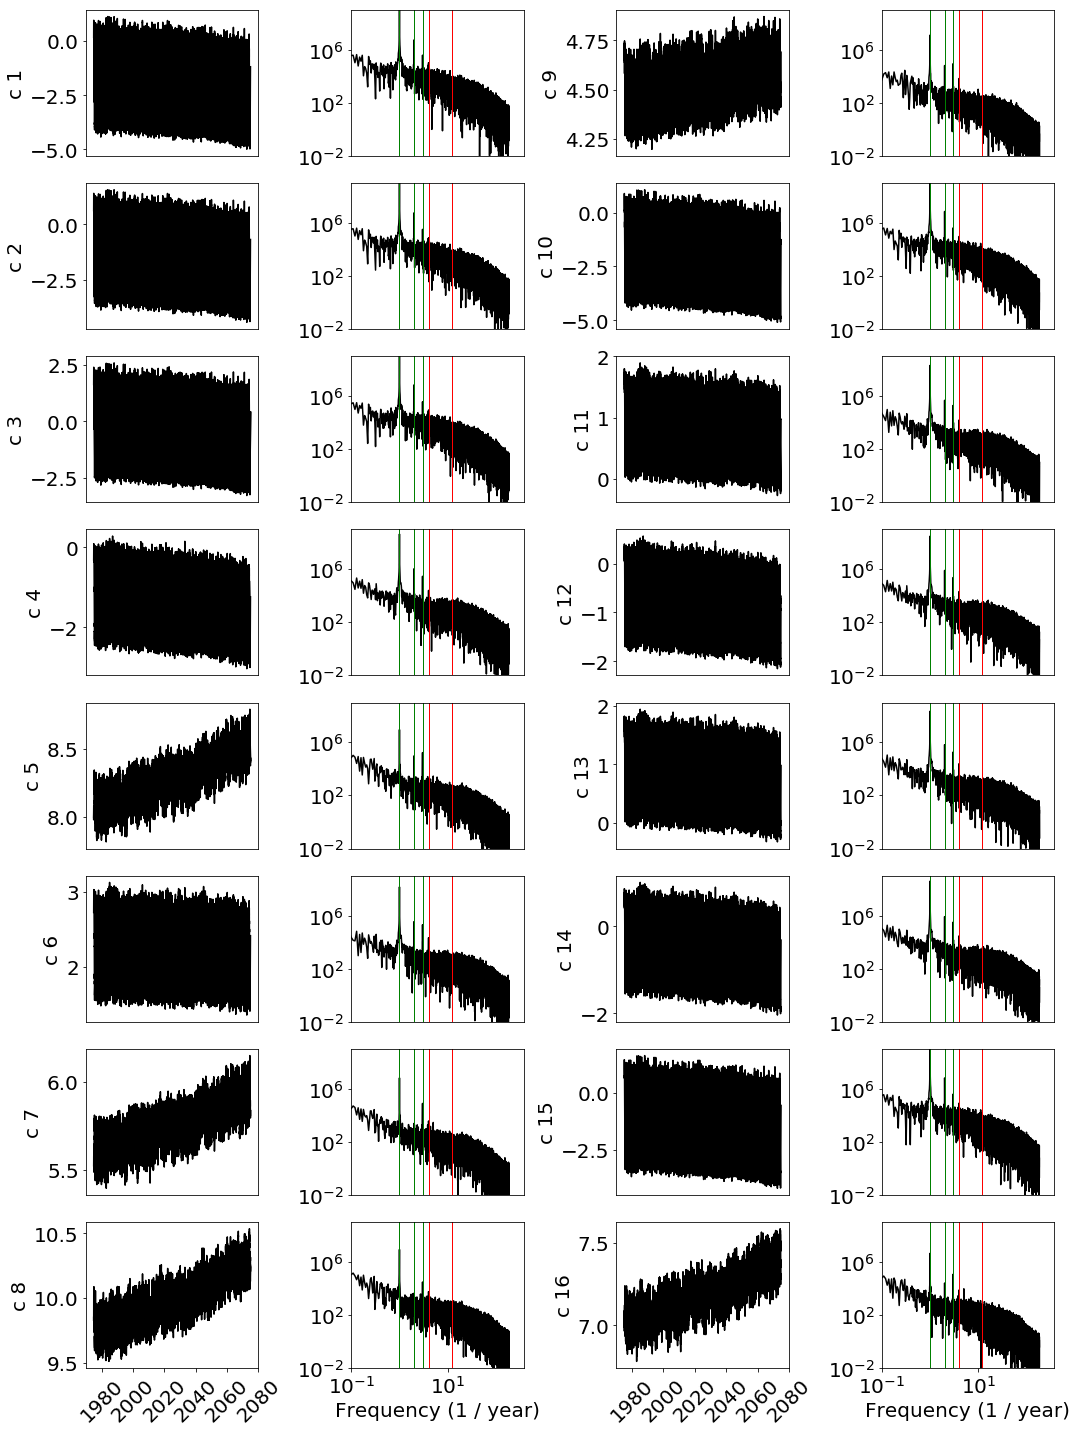

In [44]:
for j in range(1):
    time_freq_pair(datelist, ae_ts[0:(365*years_to_plot),(32*j):(32*(j+1))], 'ae', range(1+32*j,1+32*(j+1)), test_start, test_end
                   ,bottleneck=256)

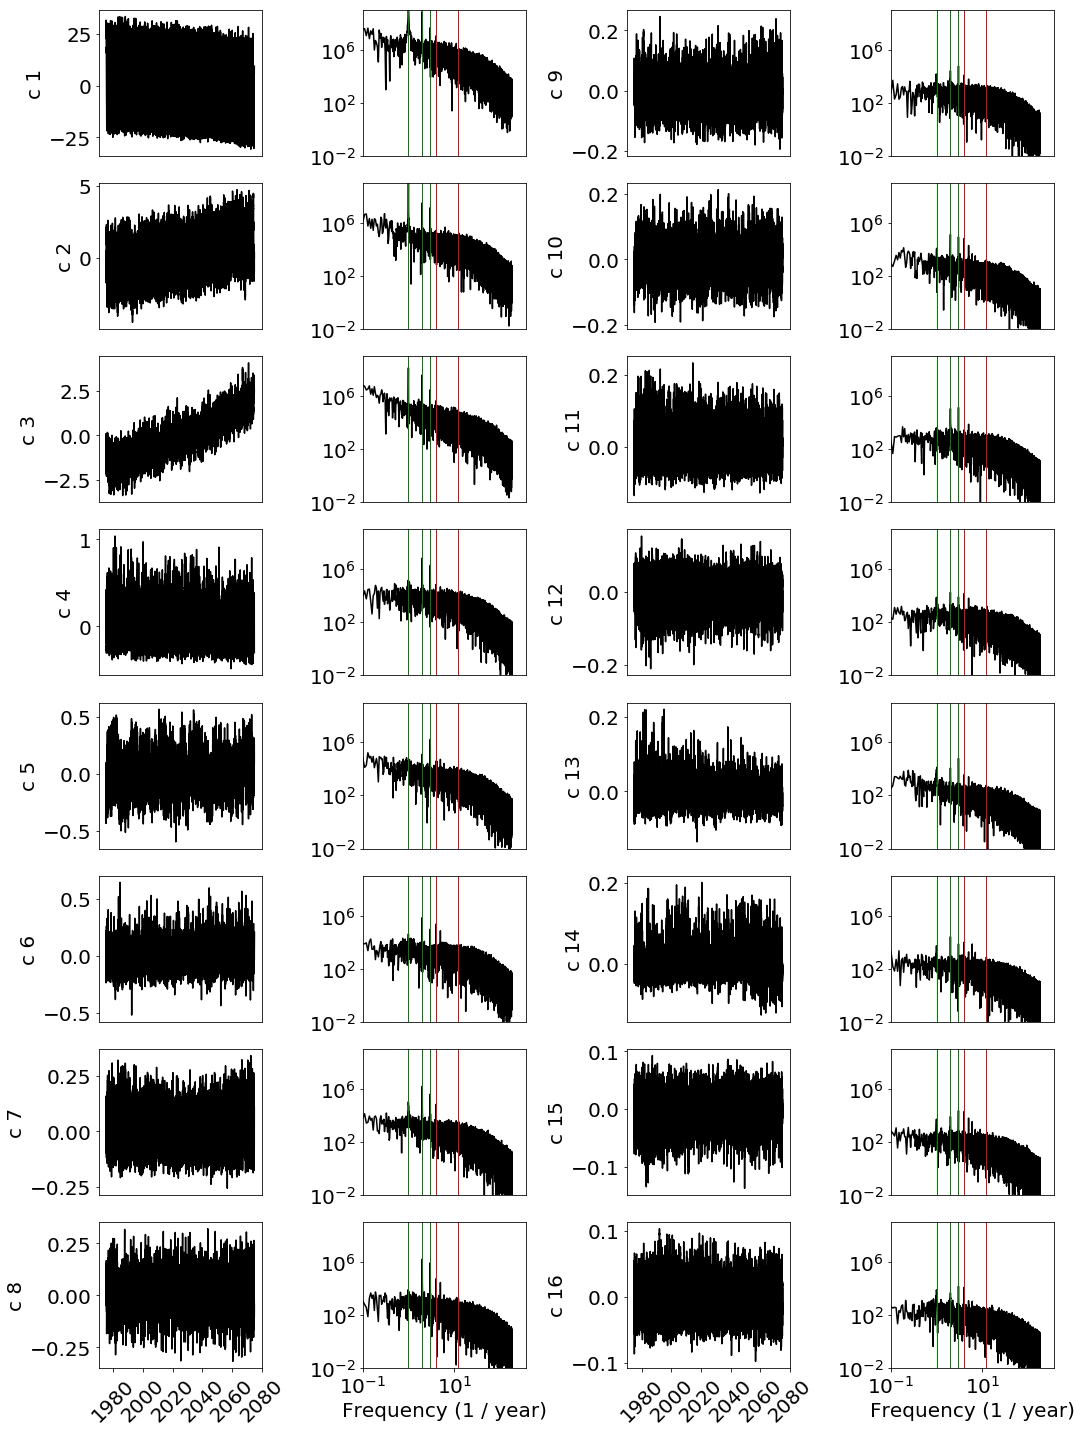

In [65]:
for j in range(1):
    time_freq_pair(datelist, pca_on_ae_ts[0:(365*years_to_plot),(32*j):(32*(j+1))], 'pca_on_ae', range(1+32*j,1+32*(j+1)), test_start, test_end
                   ,bottleneck=256)

/home/gavin/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


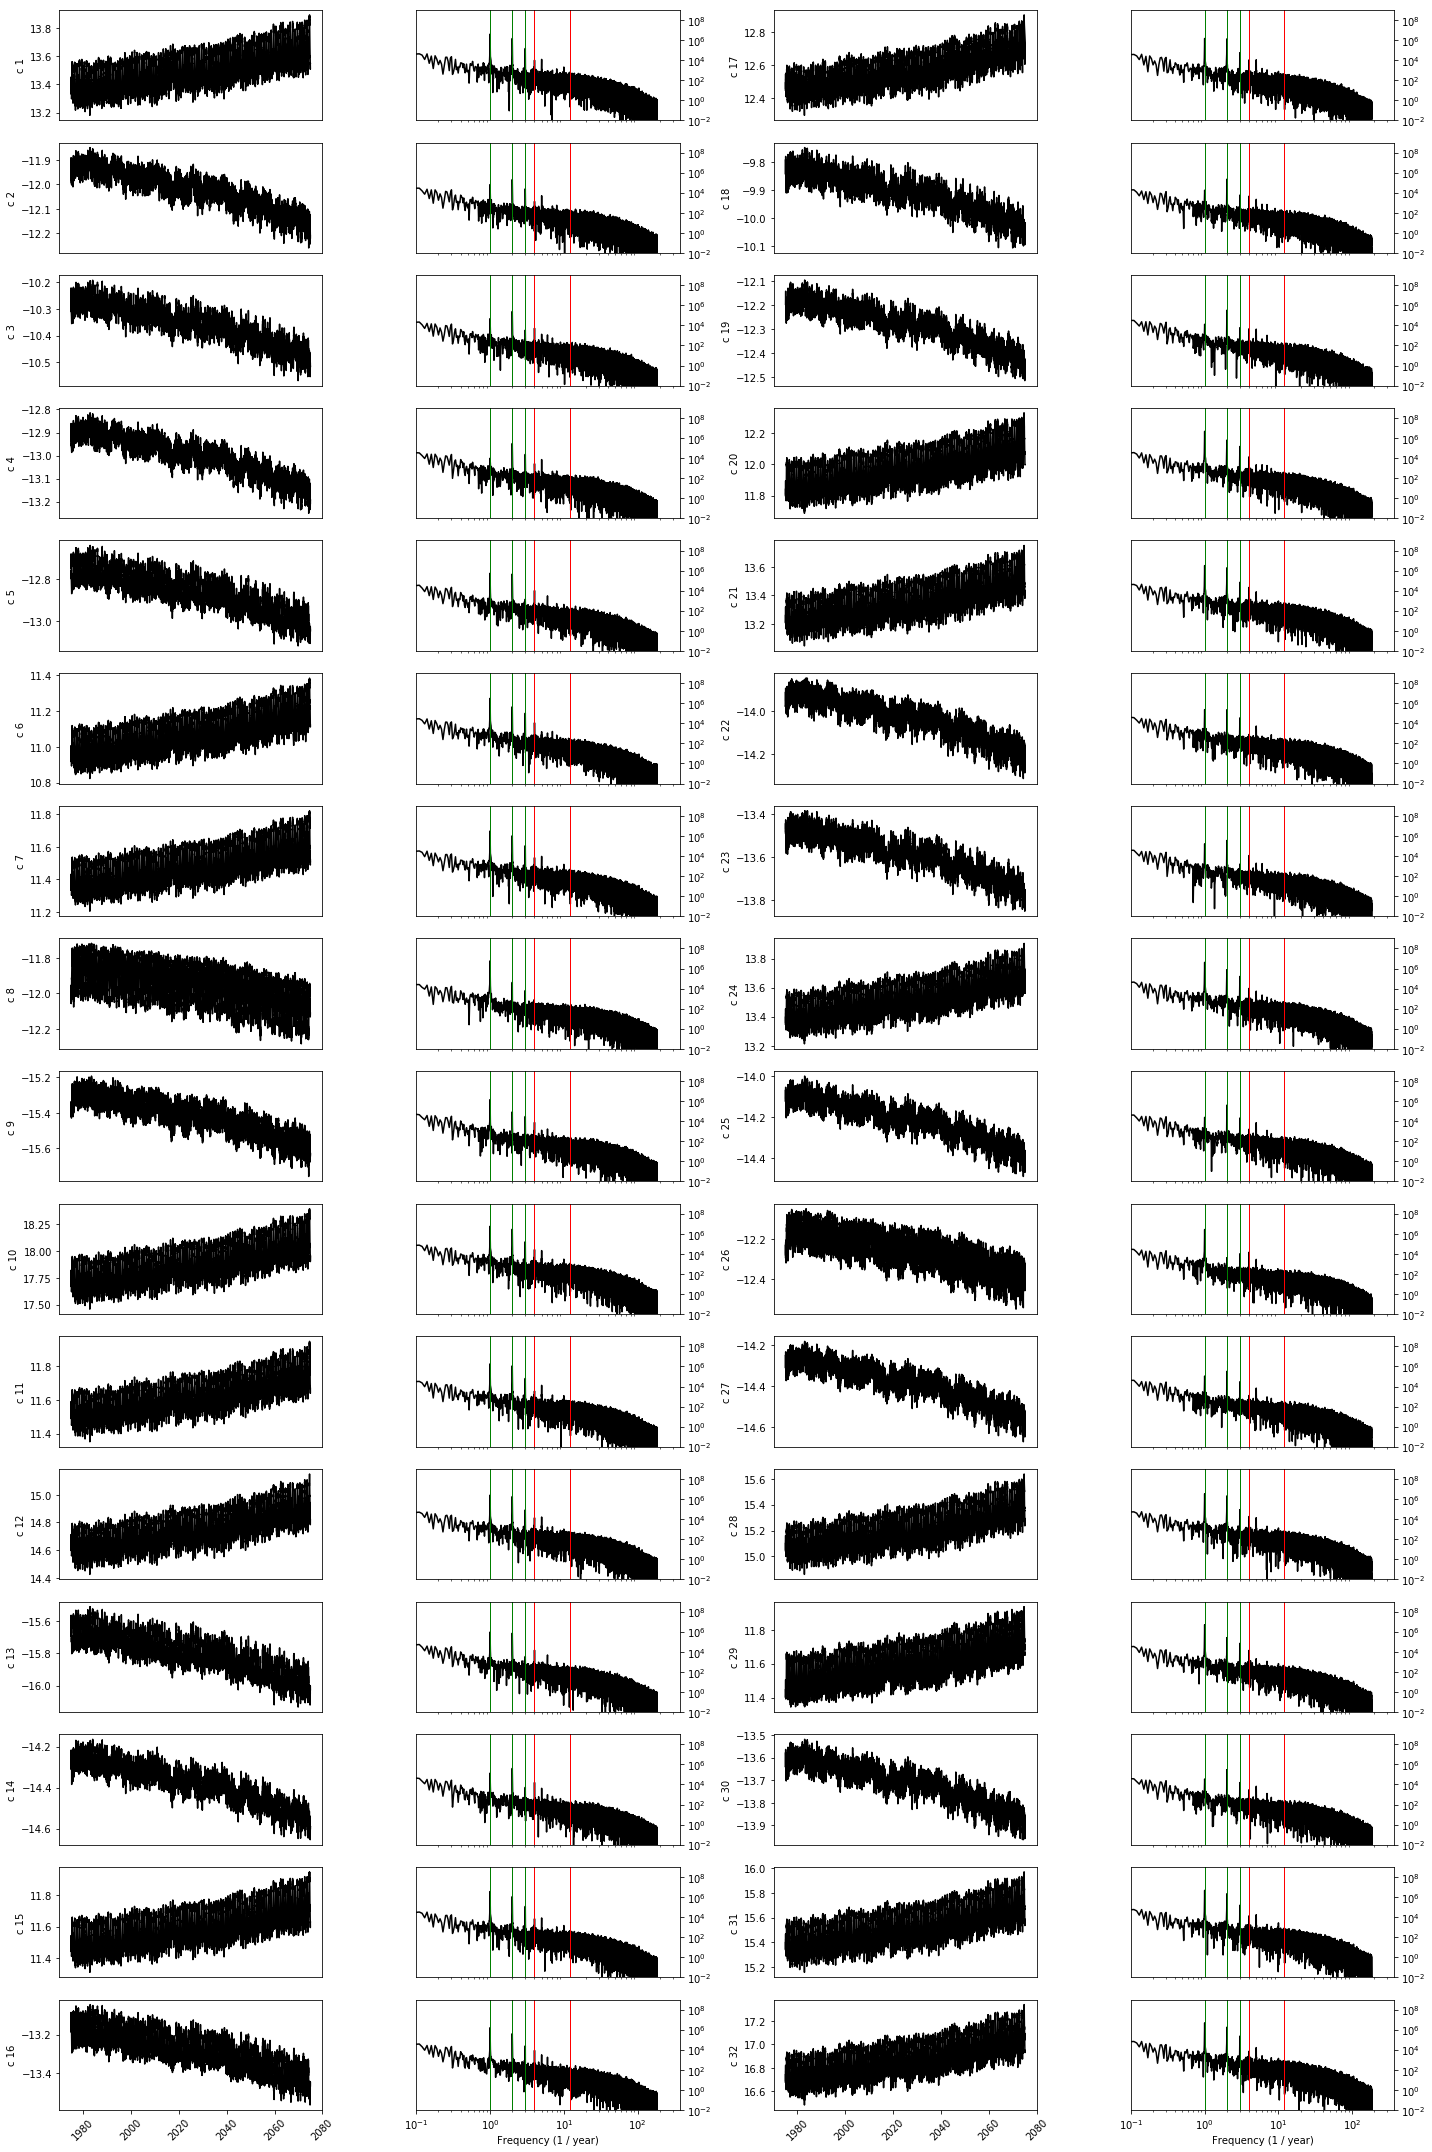

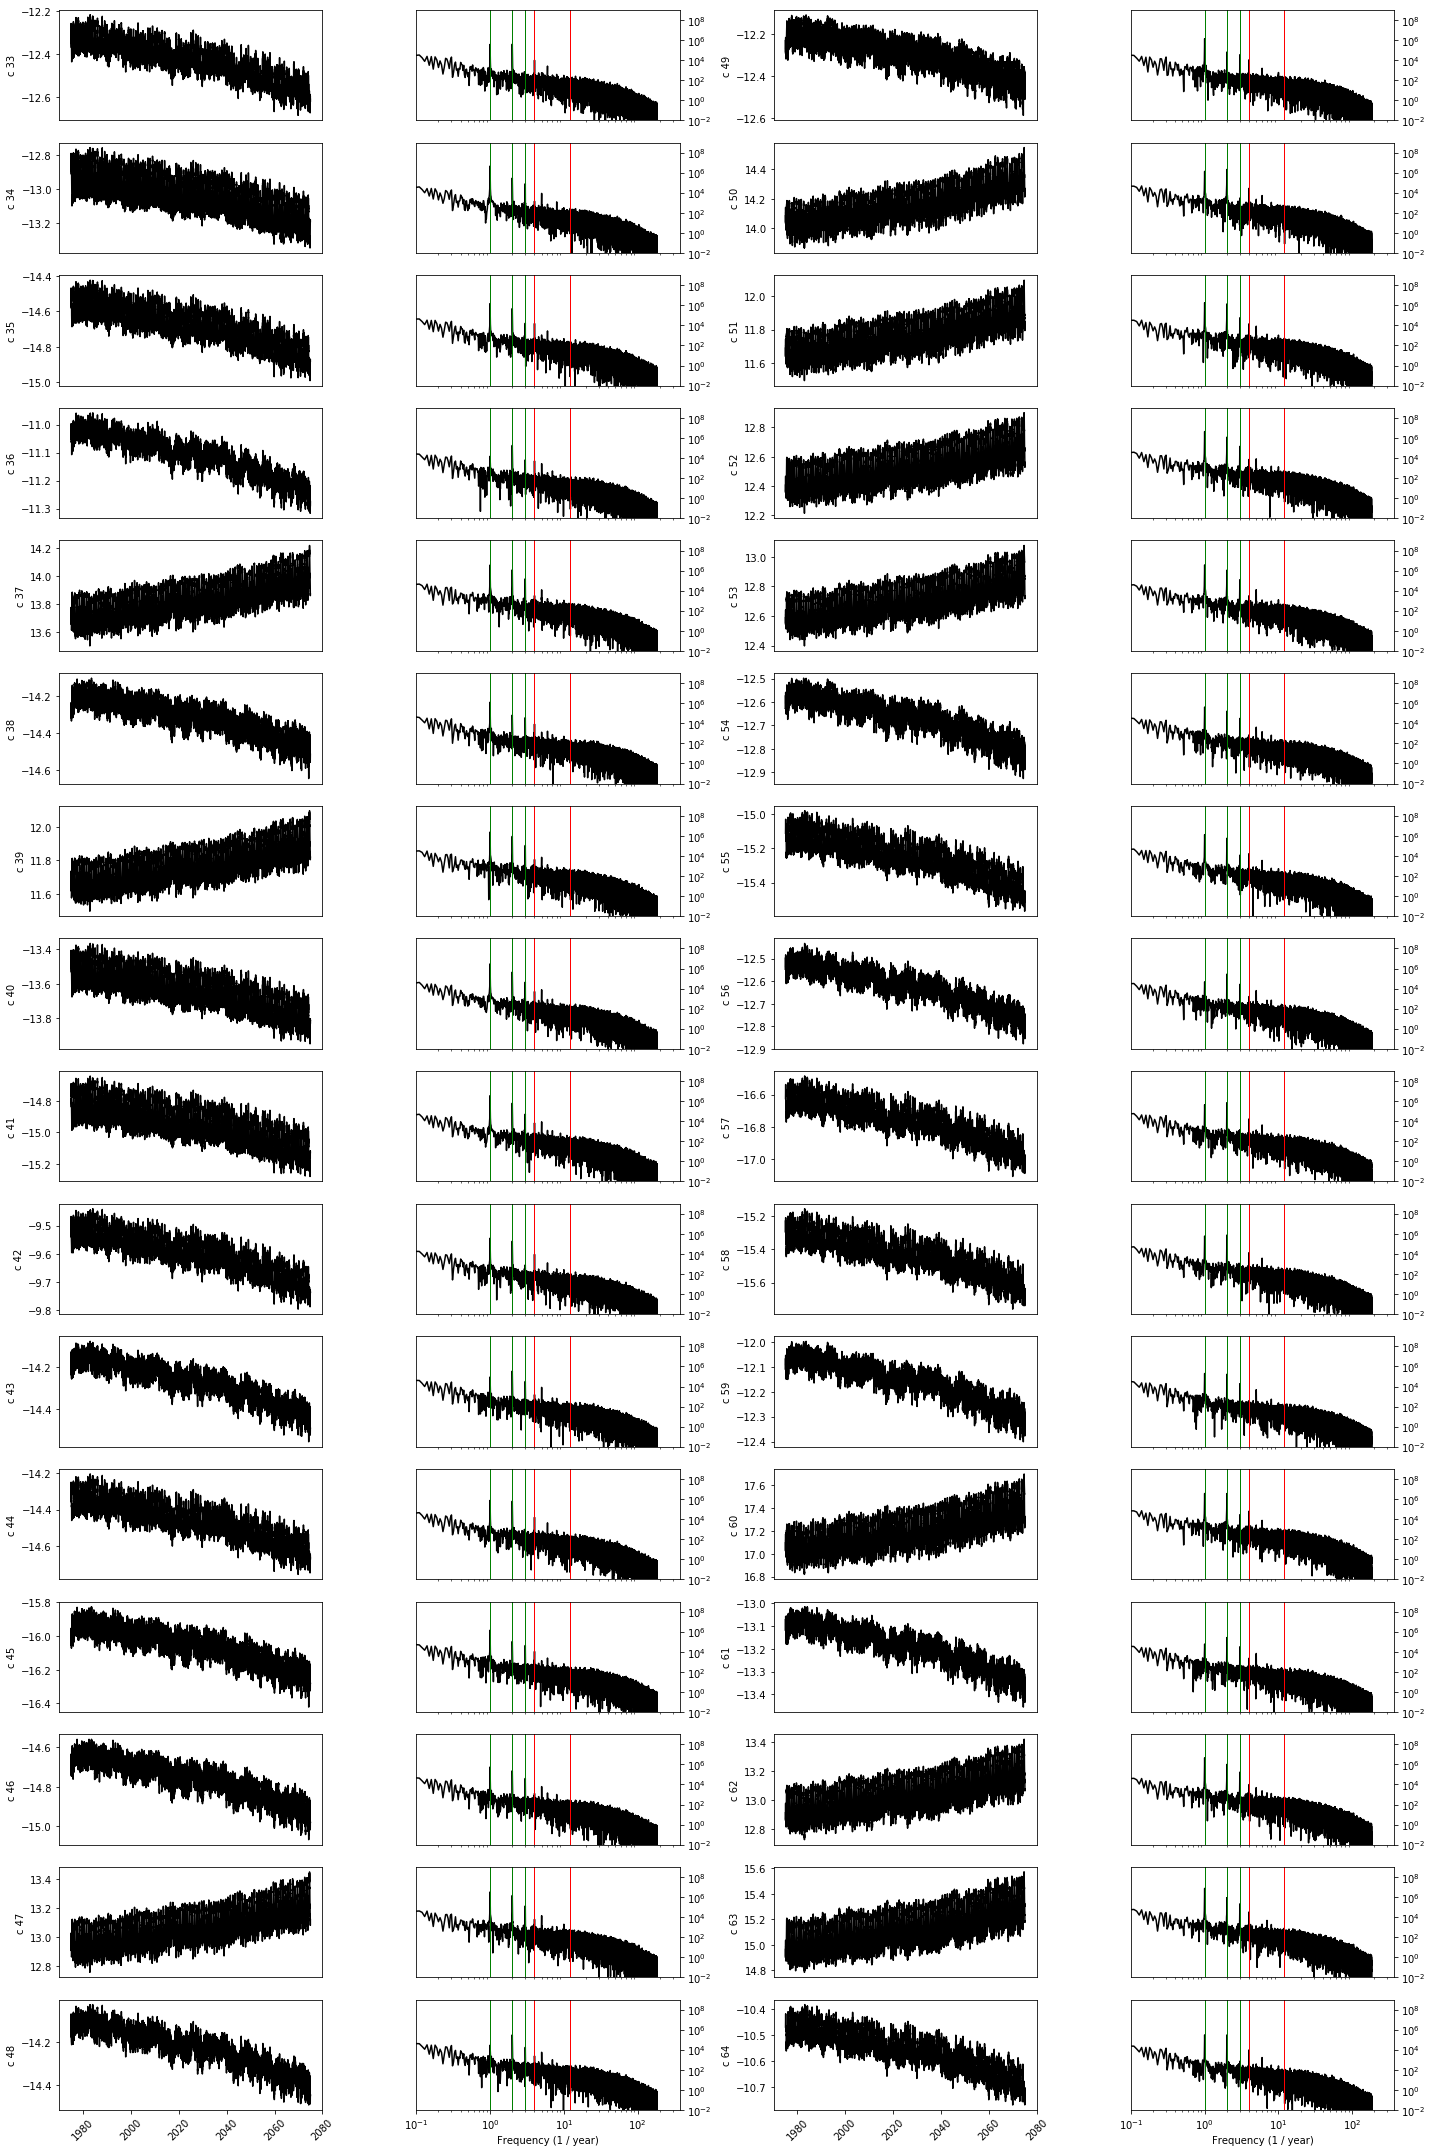

In [22]:
# time_freq_pair(datelist, pca_ts[0:(365*5),0:16])
# time_freq_pair(datelist, ae_ts[0:(365*5),0:32], 'autoencoder', range(1,32+1), test_start, test_end,bottleneck)
# time_freq_pair(datelist, pca_on_ae_ts[0:(365*5),0:32], 'pca_on_ae', range(1,32+1), test_start, test_end,bottleneck)
for j in range(2):
    time_freq_pair(datelist, ae_ts[0:(365*years_to_plot),(32*j):(32*(j+1))], 'autoencoder', range(1+32*j,1+32*(j+1)), test_start, test_end
                   ,bottleneck=64)

# time_freq_pair(datelist, pca_on_ae_ts[0:(365*5),32:], 'pca_on_ae', range(1+32,48+1), test_start, test_end,bottleneck)


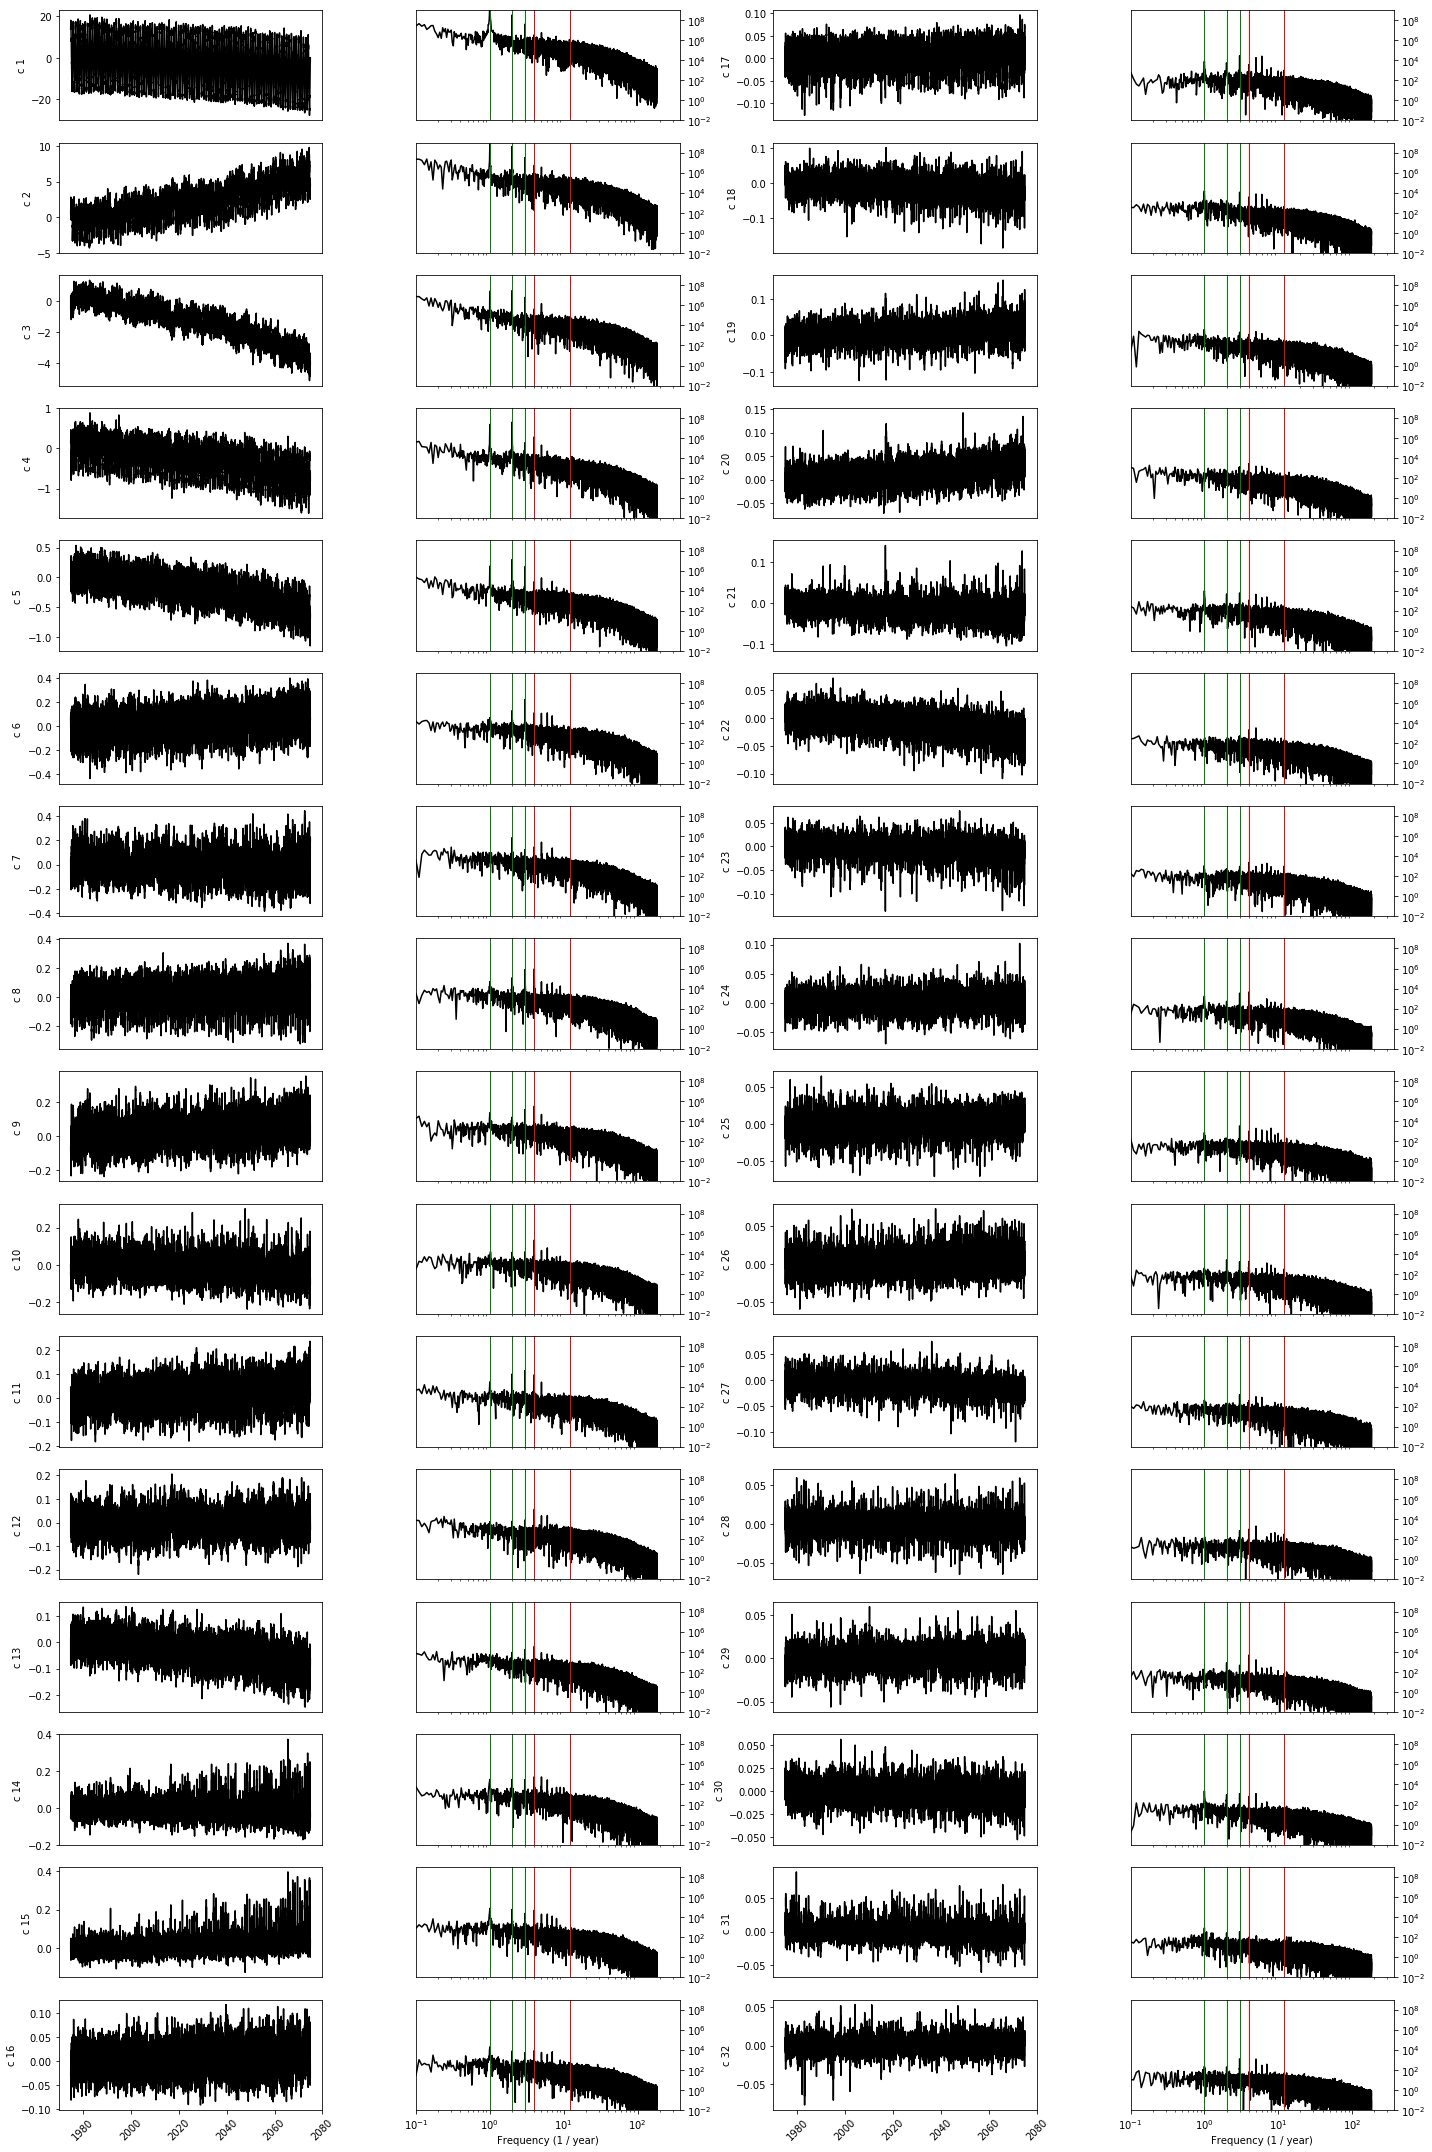

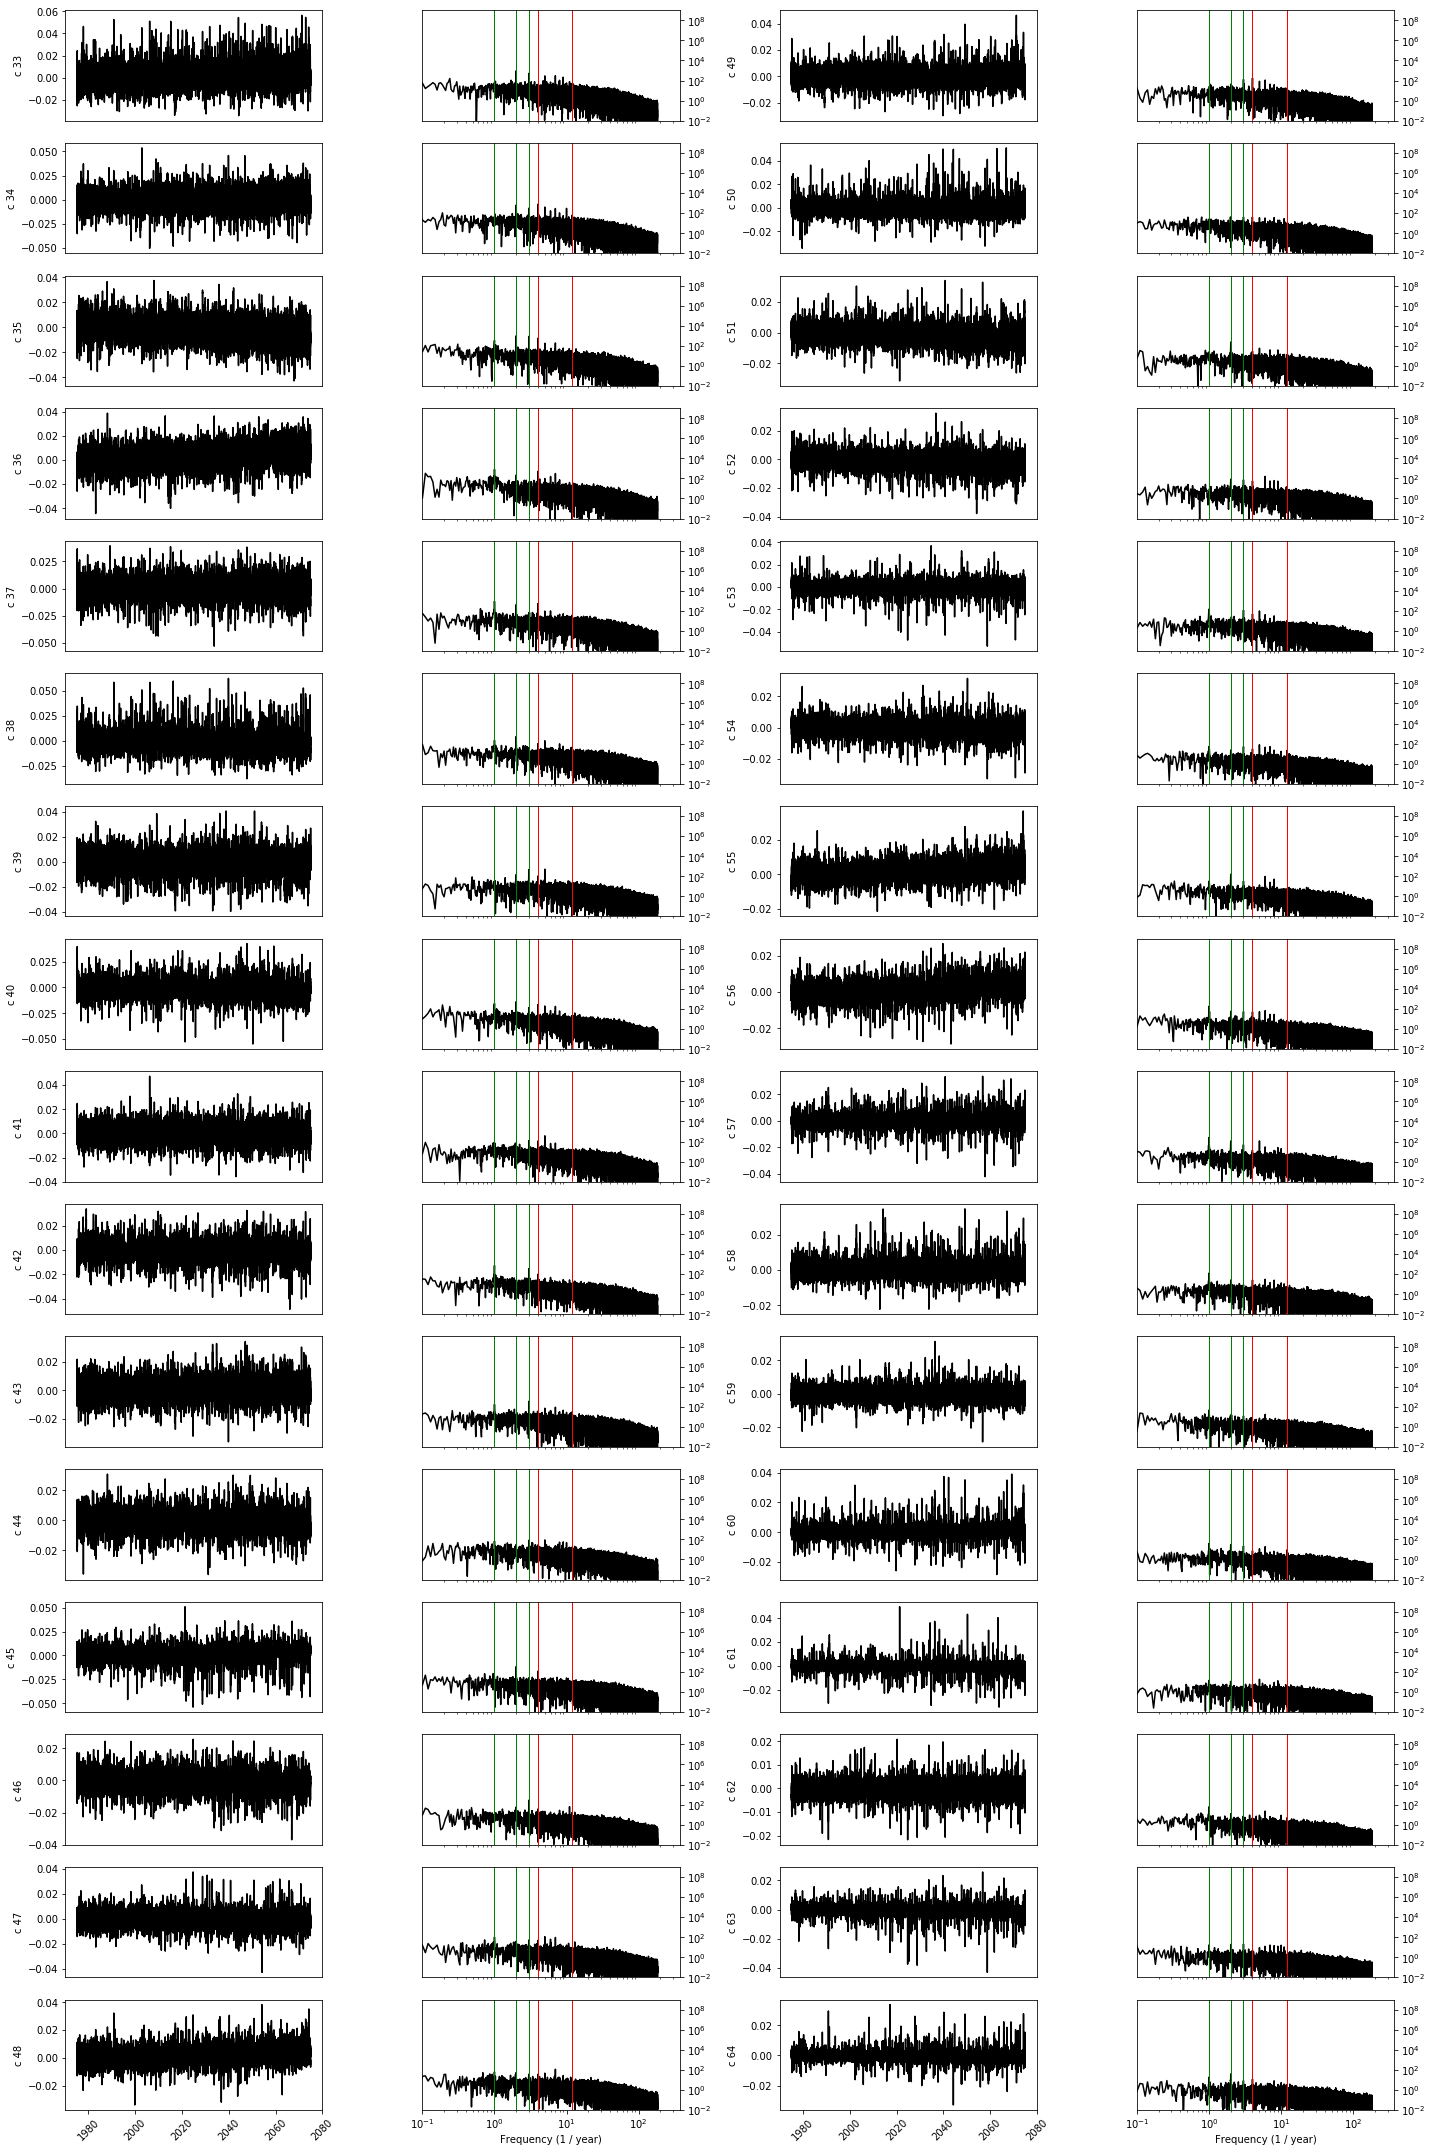

In [37]:
for k in range(2):
    time_freq_pair(datelist, pca_on_ae_ts[0:(365*years_to_plot),(32*k):(32*(k+1))], 'pca_on_ae', range(1+32*k,1+32*(k+1)), test_start, test_end
                   ,bottleneck=64)


# Visualise variance explained for PCA and PCA onautoencoder

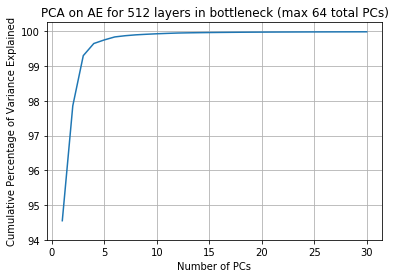

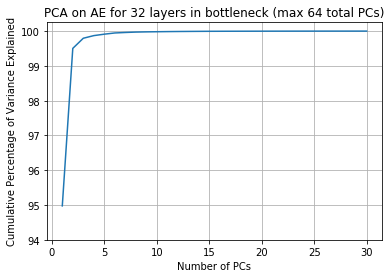

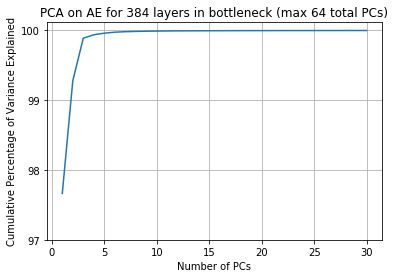

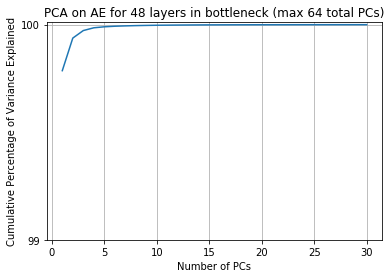

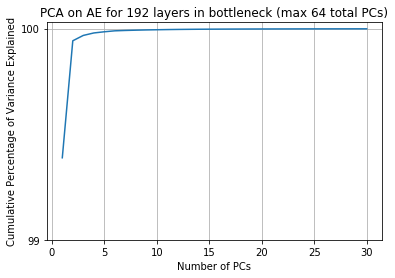

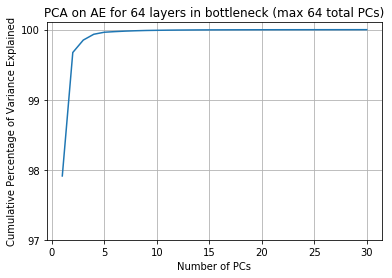

In [14]:
bottlenecks = [512, 32, 384, 48, 192, 64]
pcs=30
for b in bottlenecks:
    with open('data/models/autoencoder/pca_on_ae_{}_2025_to_2100.pickle'.format(b), 'rb') as file:
        pca_on_ae_model = pickle.load(file)
        
    fig, ax = plt.subplots()
    y = np.cumsum(pca_on_ae_model.explained_variance_ratio_)[:30]*100
    ax.plot(range(1,pcs+1),y)
    ax.set_yticks(range(int(np.floor(np.min(y))),101))
    ax.set_title("PCA on AE for {} layers in bottleneck (max 64 total PCs)".format(b))
    ax.set_ylabel("Cumulative Percentage of Variance Explained")
    ax.set_xlabel("Number of PCs")
    ax.grid()
    fig.savefig('data/images/autoencoder/pca_on_ae_variance_{}.pdf'.format(b))

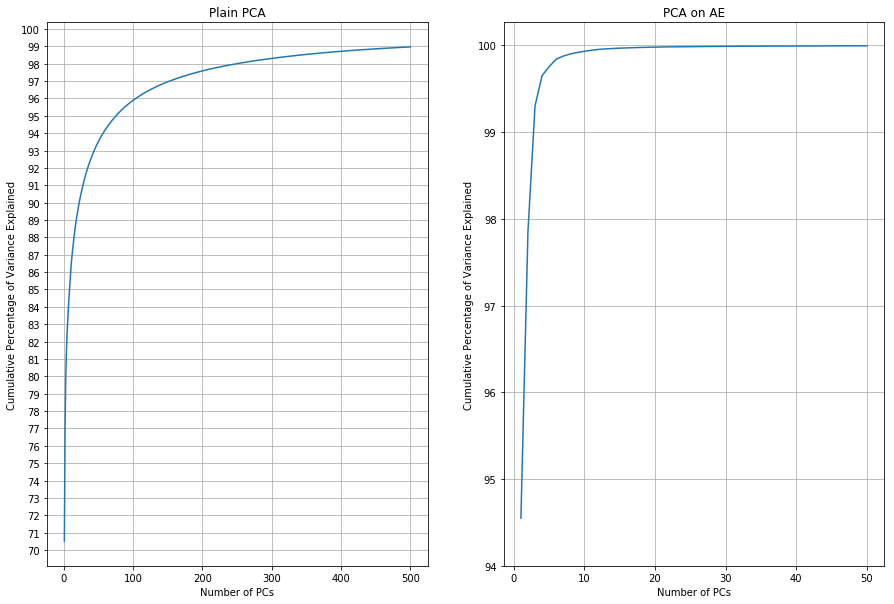

In [23]:
pcs = 500
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax[0].plot(range(1,pcs+1),np.cumsum(pca_model.explained_variance_ratio_)[:pcs]*100)
ax[0].set_yticks(range(70,101))
ax[0].set_title("Plain PCA")
ax[0].set_ylabel("Cumulative Percentage of Variance Explained")
ax[0].set_xlabel("Number of PCs")
ax[0].grid()

ae_pcs=50
ax[1].plot(range(1,ae_pcs+1),np.cumsum(pca_on_ae_model.explained_variance_ratio_)[:ae_pcs]*100)
ax[1].set_yticks(range(94,101))
ax[1].set_title("PCA on AE")
ax[1].set_ylabel("Cumulative Percentage of Variance Explained")
ax[1].set_xlabel("Number of PCs")
ax[1].grid()

plt.savefig('data/images/full/pca_comparison.pdf')

plt.show()

# What happens if we feed in images into an untrained network?

In [17]:
model = AutoEncoder(layers=[4,8,16,32,64])

Text(0.5, 1.0, 'Near-surface air temperature')

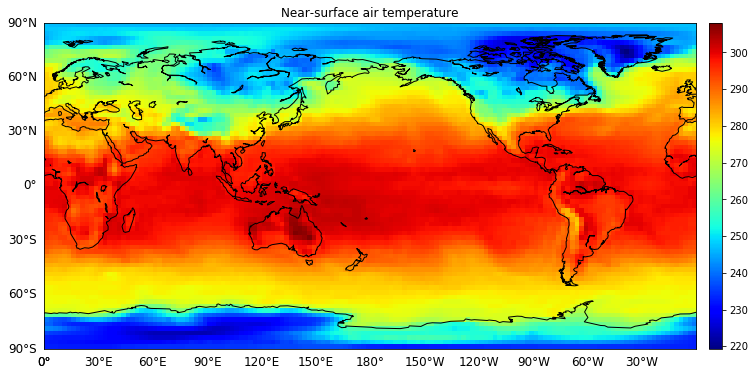

In [33]:
fig = plt.figure(figsize=(16,6))
long = [0, 360]
lat = [-90, 90]

map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
map.drawcoastlines()
map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

h = map.imshow(temp_ncdata_3D[1500,:], cmap = 'jet', interpolation = 'none', animated = True)
map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
plt.title("Near-surface air temperature")

In [30]:
_, random_output = model(torch.tensor(temp_ncdata_3D[1500,:]).reshape(1,1,72,144))

Text(0.5, 1.0, 'Near-surface air temperature')

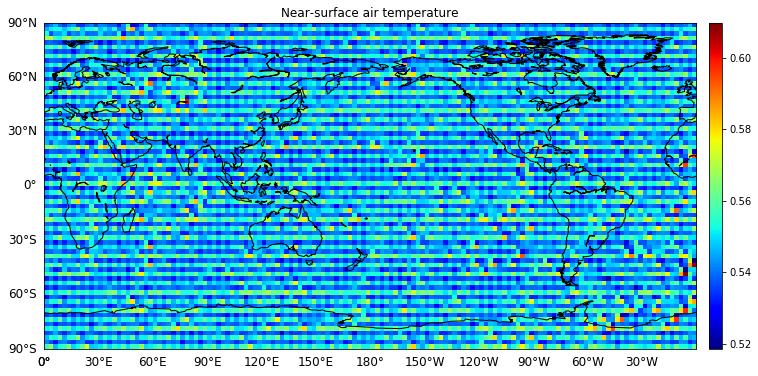

In [34]:
fig = plt.figure(figsize=(16,6))
long = [0, 360]
lat = [-90, 90]

map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
map.drawcoastlines()
map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)


h = map.imshow(random_output.detach().numpy().reshape(72,144), cmap = 'jet', interpolation = 'none', animated = True)
map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
plt.title("Near-surface air temperature")